In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from algos import *
from infect import *
from sbm import *

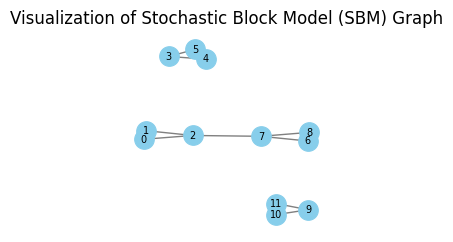

In [2]:
# SBM Testing
# from sbm import *

N = 12  # Total number of nodes
M = 4    # Number of communities
q0 = 1 # Intra-community connection probability
q1 = 0.01 # Inter-community connection probability
G = SBM(N, M, q0, q1)
visualize_graph(G)

In [3]:
# Testing infect

N = 256
M = 16
q0 = 0.5
q1 = 0.3
G = SBM(N, M, q0, q1)
# visualize_graph(G)

p0 = 0.001  # Initial infection probability
p1 = 0.3  # Probability of infection spread to neighbors
time_steps = 2  # Number of days to simulate the infection spread

infected_individuals = infect(G, p0, p1, time_steps)

# plot_infection_progression(infected_individuals)

def print_subarrays(infected_individuals, N, M):
    N = len(infected_individuals)
    group_size = N // M

    for i in range(M):
        start_index = i * group_size
        end_index = start_index + group_size
        subarray = infected_individuals[start_index:end_index]
        print(f"Community {i + 1}: {subarray}", "Num infected:", sum(subarray))

print("Number of infected individuals after 2 days are", sum(infected_individuals))
print_subarrays(infected_individuals, N, M)

Number of infected individuals after 2 days are 0
Community 1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 5: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 6: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 7: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 8: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 9: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 10: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 11: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 12: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 13: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 14: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0
Community 15: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Num infected: 0

In [4]:
# Testing naive_testing and optimized naive_testing
p = 0.99
sample_individuals = np.random.choice([0, 1], size=N, p=[1-p, p])
print(np.where(sample_individuals==0)[0])
print(naive_testing(sample_individuals)[0])
print(optimized_naive_testing(sample_individuals)[0])

[ 77  81 104 105 209 225]
256
227


In [5]:
def naive_testing(s):
    num = len(s)
    stages = 1
    return num, stages


def optimized_naive_testing(s):
    # Fix test count
    num = 0
    stages = 1
    positive_tests = 0
    negative_tests = 0

    total_infected = sum(s)
    num+=1

    proportion_of_positive_tests = total_infected/len(s)
    if proportion_of_positive_tests==0 or proportion_of_positive_tests==1: return num, stages

    if(proportion_of_positive_tests <= 0.5):
      for i in range(len(s)):
          if s[i] == 1:
            positive_tests += 1
          num+=1
          if positive_tests==sum(s): break
    else:
      for i in range(len(s)):
          if s[i] == 0:
            negative_tests += 1
          num+=1
          if negative_tests==(len(s)-sum(s)): break

    return num, stages



# binary spliting
def binary_splitting_round(s):
    # s: np.array the infectious status & test status

    # Number of tests performed
    num = 0

    # num infected > 1?
    flag = sum(s[:,0])>0
    assert flag
    # num stages till now
    stages = 0

    # if there's one person, set their test status to infection status
    if len(s[:,0])==1:
        s[0,1] = s[0,0]
        return num,s,stages

    # Split array in half
    B1, B2 = np.array_split(s.copy(), 2,axis=0)
    flag = sum(B1[:,0])>0
    num+=1
    stages += 1

    if flag:
        n,stmp,stage = binary_splitting_round(B1)
        s[:len(B1),1] = stmp[:,1]
    else:
        s[:len(B1),1] = 0
        n,stmp,stage = binary_splitting_round(B2)
        s[len(B1):,1] = stmp[:,1]
    num += n
    stages += stage
    return num,s,stages



def binary_splitting(s):
    # modified bs
    # s: 1-d array the infectious status
    st = np.zeros((len(s),2))
    st[:,0] = s
    st[:,1] = np.nan
    nums = 0
    count = sum(np.isnan(st[:,1]))
    stages = 0
    # the undetermined people
    while count!=0:
        mask = np.isnan(st[:,1])
        flag = sum(st[mask,0]>0)>0
        nums += 1
        stages+=1
        if not flag:
            st[mask,1] = 0
        else:
            n,stmp,stage = binary_splitting_round(st[mask,:])
            st[mask,1] = stmp[:,1]
            nums += n
            stages += stage
        count = sum(np.isnan(st[:,1]))

    assert sum(st[:,0]!=st[:,1])==0
    return nums,stages, st[:,1]



# def parallel_binary_helper(st):
#     if st.shape[0] == 0:
#         return 0,0
#     nums = 0
#     stages = 0
#     # flag = sum(st[:,0])>0
#     if len(st[:,0])==1:
#         st[0,1] = st[0,0]
#         return nums,stages

#     nums += 2
#     stages += 1
#     B1, B2 = np.array_split(st, 2,axis=0)
#     flag1 = sum(B1[:,0])>0
#     flag2 = sum(B2[:,0])>0
#     if flag1 and flag2:
#         n1,s1 = parallel_binary_helper(B1)
#         n2,s2 = parallel_binary_helper(B2)
#         nums += n1+n2
#         stages += max(s1,s2)
#     elif flag1:
#         n1,s1 = parallel_binary_helper(B1)
#         nums += n1
#         stages += s1
#         B2[:,1] = 0
#     elif flag2:
#         n2,s2 = parallel_binary_helper(B2)
#         nums += n2
#         stages += s2
#         B1[:,1] = 0
#     else:
#         B1[:,1] = 0
#         B2[:,1] = 0

#     return nums,stages



# def parallel_binary_splitting(s):
#     # modified bs
#     # s: 1-d array the infectious status
#     st = np.zeros((len(s),2))
#     st[:,0] = s
#     st[:,1] = np.nan
#     nums,stages = parallel_binary_helper(st)
#     assert sum(st[:,0]!=st[:,1])==0
#     return nums,stages, st[:,1]


def parallel_binary_splitting(s):
    num, stages = 0,0
    if len(s)==0: return 0,0

    num+=1
    stages += 1
    # Base Case (test incremented above)
    if sum(s) == 0 or sum(s)==len(s): return num, stages

    mid = len(s)//2
    left_half = s[:mid].copy()
    right_half = s[mid:].copy()
    
    num_left, stages_left = parallel_binary_splitting(left_half)
    num_right, stages_right = parallel_binary_splitting(right_half)
    
    num += num_left + num_right
    stages = 1 + max(stages_left,stages_right)

    return num, stages


# diag
def diagalg_iter(s):
    # s(np.array): binary string of infection status
    # Ex: [1,0,0,1,0,0,1,0]
    # k = 3 (iteration number)
    k = int(np.log2(len(s)))
    # l = 4
    l = int(2**(k-1))
    lp = 0
    # p = [0,0,0,0] (num_of_groups)
    p = np.zeros(k+1)
    group = dict()
    # num = [1,1,1,1]
    num = np.ones(k+1,dtype=np.int32)
    for i in range(k):
        p[i] = sum(s[lp:lp+l])>0
        group[i] = s[lp:lp+l]
        num[i] = l
        lp+=l
        l = l//2

    p[-1] = s[-1]
    group[k] = np.array([s[-1]])
    # p(array): pattern
    # group(dict): indicate the group information
    # num(array): the group size
    return p.astype(np.int32), group,num


def diag_splitting(s):
    # s(np.array): binary string of infection status
    num_tests = 0
    stages = 0
    pattern, group, nums = diagalg_iter(s)
    stages +=1
    num_tests += len(pattern)
    indices = np.where(pattern == 1)[0]
    flag = 0
    for i in indices:
        if nums[i]>1:
            num_test,stage = diag_splitting(group[i])
            num_tests += num_test
            if not flag:
                stages+=stage
                flag = 1
    return num_tests,stages

def Qtesting1(s, stage=1, max_stages=5):
    # Adaptive threshold based on the current stage
    # threshold = 0.2 - (stage / max_stages) * 0.01
    threshold = 0.2

    if sum(s) / len(s) > threshold:
        num, stages = optimized_naive_testing(s)
        return num, stages

    # s(np.array): binary string of infection status
    num_tests = 0
    stages = 0
    pattern, group, nums = diagalg_iter(s)
    stages += 1
    # pattern is the test_result for each group
    num_tests += len(pattern)

    # All groups which tested positive
    indices = np.where(pattern == 1)[0]
    flag = 0
    for i in indices:
        if nums[i] > 1:
            num_test, stage = Qtesting1(group[i], stage + 1, max_stages)
            num_tests += num_test
            if not flag:
                stages += stage
                flag = 1
    return num_tests, stages


def Qtesting1_bin(s):
    # modified bs
    # s: 1-d array the infectious status
    threshold = 0.2
    num_infected = sum(s)

    if num_infected/len(s) > threshold:
        num, stages = optimized_naive_testing(s)
        return num, stages

    num,stages = parallel_binary_splitting(s)
    return num,stages


def Qtesting2(s):
    '''
    s(np.array): binary string of infection status
    '''
    num_tests = 0
    stages = 0
    ###################################################
    '''your code here'''

    ###################################################



    return num_tests,stages



def Qtesting1_comm_aware(s, communities):
    '''
    s(np.array): binary string of infection status
    communities(list): the community information
    '''
    num_tests = 0
    stages = 0
    communities = np.array(communities)
    s = np.array(s)

    for community in communities:
        temp_tests, temp_stages = Qtesting1(s[community])
        num_tests += temp_tests
        stages = max(temp_stages,stages)

    return num_tests, stages


def Qtesting1_comm_aware_bin(s, communities):
    '''
    s(np.array): binary string of infection status
    communities(list): the community information
    '''
    num_tests = 0
    stages = 0
    communities = np.array(communities)
    s = np.array(s)


    for community in communities:
        num_tests += 1
        if sum(community) == 0: continue
        if sum(community)/len(community) <= 1/128:
            temp_tests, temp_stages = Qtesting1_bin(s[community])
            num_tests += temp_tests
        else:
            temp_tests, temp_stages = Qtesting1(s[community])
            num_tests += temp_tests
        stages = max(temp_stages,stages)

    return num_tests, stages



def Qtesting2_comm_aware(s,communities):
    '''
    s(np.array): binary string of infection status
    communities(list): the community information
    '''
    num_tests = 0
    stages = 0
    ###################################################
    '''your code here'''

    ###################################################



    return num_tests,stages

In [31]:
def group_division_testing(s):
    num, stages = 0, 0
    if len(s) == 0: 
        return num, stages


    num_infected = sum(s)
    num+=1
    stages += 1

    if num_infected/len(s) < 0.05:
        bin_num, bin_stages = parallel_binary_splitting(s)
        num += bin_num
        stages += bin_stages
        return num, stages
    
    group_size = max(1, len(s) // 64)
    groups = [s[i:i + group_size] for i in range(0, len(s), group_size)]
    
    # Apply parallel binary splitting on each group
    for group in groups:
        if len(group) > 1:
            num_sub, stages_sub = Qtesting1_bin(group)
            num += num_sub
            stages = max(stages, stages_sub)
    
    return num, stages

# Example usage:
infection_probability = 0.01
array = np.random.choice([0, 1], size=256, p=[1 - infection_probability, infection_probability])
tests, stages = group_division_testing(array)
print("group_division_testing:", tests, stages)


group_division_testing: 2 2


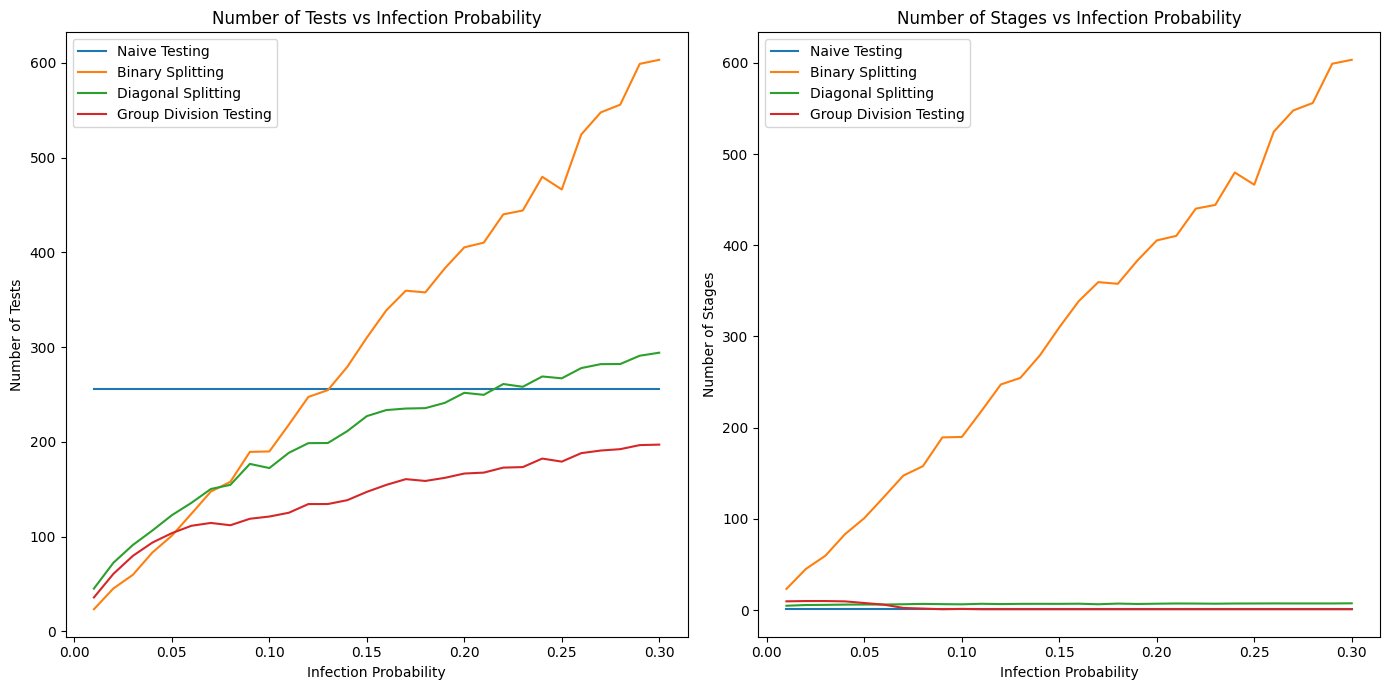

In [30]:
# Set a seed for reproducibility
# np.random.seed(42)


# Number of simulations to average over
num_simulations = 25

# Initialize lists to store results
infection_probs = np.arange(0.01, 0.31, 0.01)
naive_tests_list = []
binary_tests_list = []
parallel_binary_tests_list = []
diag_tests_list = []
Q1_tests_list = []
group_division_tests_list = []

naive_stages_list = []
binary_stages_list = []
parallel_binary_stages_list = []
diag_stages_list = []
Q1_stages_list = []
group_division_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    naive_tests_avg, binary_tests_avg, parallel_binary_tests_avg = 0, 0, 0
    diag_tests_avg, Q1_tests_avg, group_division_tests_avg = 0, 0, 0
    naive_stages_avg, binary_stages_avg, parallel_binary_stages_avg = 0, 0, 0
    diag_stages_avg, Q1_stages_avg, group_division_stages_avg = 0, 0, 0
    
    for _ in range(num_simulations):  # Average over num_simulations tests
        array = np.random.choice([0, 1], size=256, p=[1 - p, p])

        naive_tests, naive_stages = naive_testing(array)
        binary_tests, binary_stages = binary_splitting(array)[0:2]
        parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
        diag_tests, diag_stages = diag_splitting(array)
        Q1_tests, Q1_stages = Qtesting1(array)
        group_division_tests, group_division_stages = group_division_testing(array)

        naive_tests_avg += naive_tests
        binary_tests_avg += binary_tests
        parallel_binary_tests_avg += parallel_binary_tests
        diag_tests_avg += diag_tests
        Q1_tests_avg += Q1_tests
        group_division_tests_avg += group_division_tests

        naive_stages_avg += naive_stages
        binary_stages_avg += binary_stages
        parallel_binary_stages_avg += parallel_binary_stages
        diag_stages_avg += diag_stages
        Q1_stages_avg += Q1_stages
        group_division_stages_avg += group_division_stages

    naive_tests_list.append(naive_tests_avg / num_simulations)
    binary_tests_list.append(binary_tests_avg / num_simulations)
    parallel_binary_tests_list.append(parallel_binary_tests_avg / num_simulations)
    diag_tests_list.append(diag_tests_avg / num_simulations)
    Q1_tests_list.append(Q1_tests_avg / num_simulations)
    group_division_tests_list.append(group_division_tests_avg / num_simulations)

    naive_stages_list.append(naive_stages_avg / num_simulations)
    binary_stages_list.append(binary_stages_avg / num_simulations)
    parallel_binary_stages_list.append(parallel_binary_stages_avg / num_simulations)
    diag_stages_list.append(diag_stages_avg / num_simulations)
    Q1_stages_list.append(Q1_stages_avg / num_simulations)
    group_division_stages_list.append(group_division_stages_avg / num_simulations)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, naive_tests_list, label='Naive Testing')
plt.plot(infection_probs, binary_tests_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_tests_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_tests_list, label='Diagonal Splitting')
# plt.plot(infection_probs, Q1_tests_list, label='Q1 Testing')
plt.plot(infection_probs, group_division_tests_list, label='Group Division Testing')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, naive_stages_list, label='Naive Testing')
plt.plot(infection_probs, binary_stages_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_stages_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_stages_list, label='Diagonal Splitting')
# plt.plot(infection_probs, Q1_stages_list, label='Q1 Testing')
plt.plot(infection_probs, group_division_stages_list, label='Group Division Testing')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function Tests

infection_probability = 0.01
iterations = 100

# Initialize arrays to store results
naive_tests_results = []
naive_stages_results = []
opt_naive_tests_results = []
opt_naive_stages_results = []
parallel_binary_tests_results = []
parallel_binary_stages_results = []
diag_tests_results = []
diag_stages_results = []
Q1_tests_results = []
Q1_stages_results = []
Q1_bin_tests_results = []
Q1_bin_stages_results = []

for _ in range(iterations):
    array = np.random.choice([0, 1], size=256, p=[1 - infection_probability, infection_probability])
    
    naive_tests, naive_stages = naive_testing(array)
    naive_tests_results.append(naive_tests)
    naive_stages_results.append(naive_stages)
    
    opt_naive_tests, opt_naive_stages = optimized_naive_testing(array)
    opt_naive_tests_results.append(opt_naive_tests)
    opt_naive_stages_results.append(opt_naive_stages)
    
    parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
    parallel_binary_tests_results.append(parallel_binary_tests)
    parallel_binary_stages_results.append(parallel_binary_stages)
    
    diag_tests, diag_stages = diag_splitting(array)
    diag_tests_results.append(diag_tests)
    diag_stages_results.append(diag_stages)
    
    Q1_tests, Q1_stages = Qtesting1(array)
    Q1_tests_results.append(Q1_tests)
    Q1_stages_results.append(Q1_stages)
    
    Q1_bin_tests, Q1_bin_stages = Qtesting1_bin(array)
    Q1_bin_tests_results.append(Q1_bin_tests)
    Q1_bin_stages_results.append(Q1_bin_stages)

# Calculate averages
avg_naive_tests = np.mean(naive_tests_results)
avg_naive_stages = np.mean(naive_stages_results)
avg_opt_naive_tests = np.mean(opt_naive_tests_results)
avg_opt_naive_stages = np.mean(opt_naive_stages_results)
avg_parallel_binary_tests = np.mean(parallel_binary_tests_results)
avg_parallel_binary_stages = np.mean(parallel_binary_stages_results)
avg_diag_tests = np.mean(diag_tests_results)
avg_diag_stages = np.mean(diag_stages_results)
avg_Q1_tests = np.mean(Q1_tests_results)
avg_Q1_stages = np.mean(Q1_stages_results)
avg_Q1_bin_tests = np.mean(Q1_bin_tests_results)
avg_Q1_bin_stages = np.mean(Q1_bin_stages_results)

# Print results
print(f"Average results for infection probability = {infection_probability} over {iterations} iterations:")
print(f"Naive: {avg_naive_tests:.2f} tests, {avg_naive_stages:.2f} stages")
print(f"Optimized Naive: {avg_opt_naive_tests:.2f} tests, {avg_opt_naive_stages:.2f} stages")
print(f"Parallel Binary: {avg_parallel_binary_tests:.2f} tests, {avg_parallel_binary_stages:.2f} stages")
print(f"Diag: {avg_diag_tests:.2f} tests, {avg_diag_stages:.2f} stages")
print(f"Q1: {avg_Q1_tests:.2f} tests, {avg_Q1_stages:.2f} stages")
print(f"Q1 Bin: {avg_Q1_bin_tests:.2f} tests, {avg_Q1_bin_stages:.2f} stages")

In [ ]:


def entropy(p):
    """Calculate the entropy of a binary random variable with probability p."""
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def calculate_group_entropy(group, s):
    """Calculate the entropy of a group based on infection statuses."""
    infected_count = np.sum(s[group])
    group_size = len(group)
    p_infected = infected_count / group_size
    return entropy(p_infected)

def expected_information_gain(group, s):
    """Calculate the expected information gain of testing a group."""
    group_entropy = calculate_group_entropy(group, s)
    return group_entropy

def Qtesting1_temp(s, threshold=0.2):
    """Perform group testing using information theoretic methods."""
    if np.mean(s) > threshold:
        # Perform optimized naive testing if the infection rate is high
        num_tests = len(s)
        stages = 1
        return num_tests, stages

    num_tests = 0
    stages = 0
    groups = [np.arange(len(s))]

    while groups:
        new_groups = []
        for group in groups:
            # Perform a test on the group
            num_tests += 1
            infected_count = np.sum(s[group])

            if len(group) == 1:
                continue  # No need to split a single individual

            # Calculate the expected information gain of splitting the group
            split_point = len(group) // 2
            group1 = group[:split_point]
            group2 = group[split_point:]

            ig1 = expected_information_gain(group1, s)
            ig2 = expected_information_gain(group2, s)

            if ig1 > 0 and ig2 > 0:
                new_groups.append(group1)
                new_groups.append(group2)
            else:
                # If the group tests positive, add its subgroups for further testing
                if infected_count > 0:
                    if len(group1) > 1:
                        new_groups.append(group1)
                    if len(group2) > 1:
                        new_groups.append(group2)
                stages += 1

        groups = new_groups

    return num_tests, stages



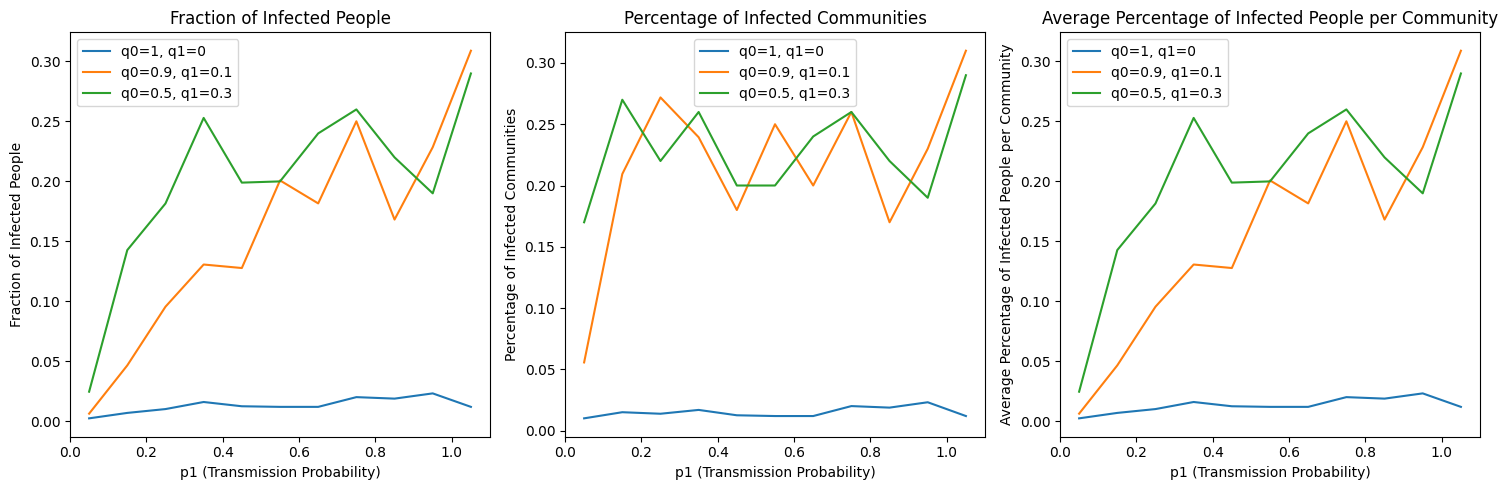

In [ ]:
# SBM STUFF: FAMILY AVERAGES, ETC ACROSS 100

# Simulation parameters
N = 256
M = 16
q_values = [(1, 0), (0.9, 0.1), (0.5, 0.3)]
p0 = 0.001
p1_values = np.arange(0.05, 1.1, 0.1)
time_steps = 2
num_simulations = 100

# Data structures to hold results
fraction_infected_people = {q: [] for q in q_values}
percentage_infected_communities = {q: [] for q in q_values}
average_infected_people_per_community = {q: [] for q in q_values}

# Run simulations
for q0, q1 in q_values:
    for p1 in p1_values:
        total_fraction_infected = 0
        total_percentage_infected_communities = 0
        total_average_infected_per_community = 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            final_infections = infect(G, p0, p1, time_steps)

            fraction_infected = np.sum(final_infections) / N
            total_fraction_infected += fraction_infected

            infected_communities = 0
            infected_counts_per_community = []
            communities = np.array_split(np.arange(N), M)

            for community in communities:
                infected_count = np.sum(final_infections[community])
                infected_counts_per_community.append(infected_count / len(community))
                if infected_count > 0:
                    infected_communities += 1

            percentage_infected_communities_sim = infected_communities / M
            total_percentage_infected_communities += percentage_infected_communities_sim

            average_infected_per_community = np.mean(infected_counts_per_community)
            total_average_infected_per_community += average_infected_per_community

        fraction_infected_people[(q0, q1)].append(total_fraction_infected / num_simulations)
        percentage_infected_communities[(q0, q1)].append(total_percentage_infected_communities / num_simulations)
        average_infected_people_per_community[(q0, q1)].append(total_average_infected_per_community / num_simulations)

# Plotting results
plt.figure(figsize=(15, 5))

# Fraction of infected people
plt.subplot(1, 3, 1)
for q in q_values:
    plt.plot(p1_values, fraction_infected_people[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Fraction of Infected People')
plt.title('Fraction of Infected People')
plt.legend()

# Percentage of infected communities
plt.subplot(1, 3, 2)
for q in q_values:
    plt.plot(p1_values, percentage_infected_communities[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Percentage of Infected Communities')
plt.title('Percentage of Infected Communities')
plt.legend()

# Average percentage of infected people per community
plt.subplot(1, 3, 3)
for q in q_values:
    plt.plot(p1_values, average_infected_people_per_community[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Average Percentage of Infected People per Community')
plt.title('Average Percentage of Infected People per Community')
plt.legend()

plt.tight_layout()
plt.show()



In [155]:
def create_communities(N, M):
    """
    Function to create communities with approximately equal number of nodes.

    Parameters:
    N (int): Total number of nodes.
    M (int): Number of communities.

    Returns:
    List[List[int]]: 2D array of indices for each community.
    """
    communities = []
    nodes_per_community = N // M
    extra_nodes = N % M

    start = 0
    for i in range(M):
        end = start + nodes_per_community + (1 if i < extra_nodes else 0)
        communities.append(list(range(start, end)))
        start = end

    return communities

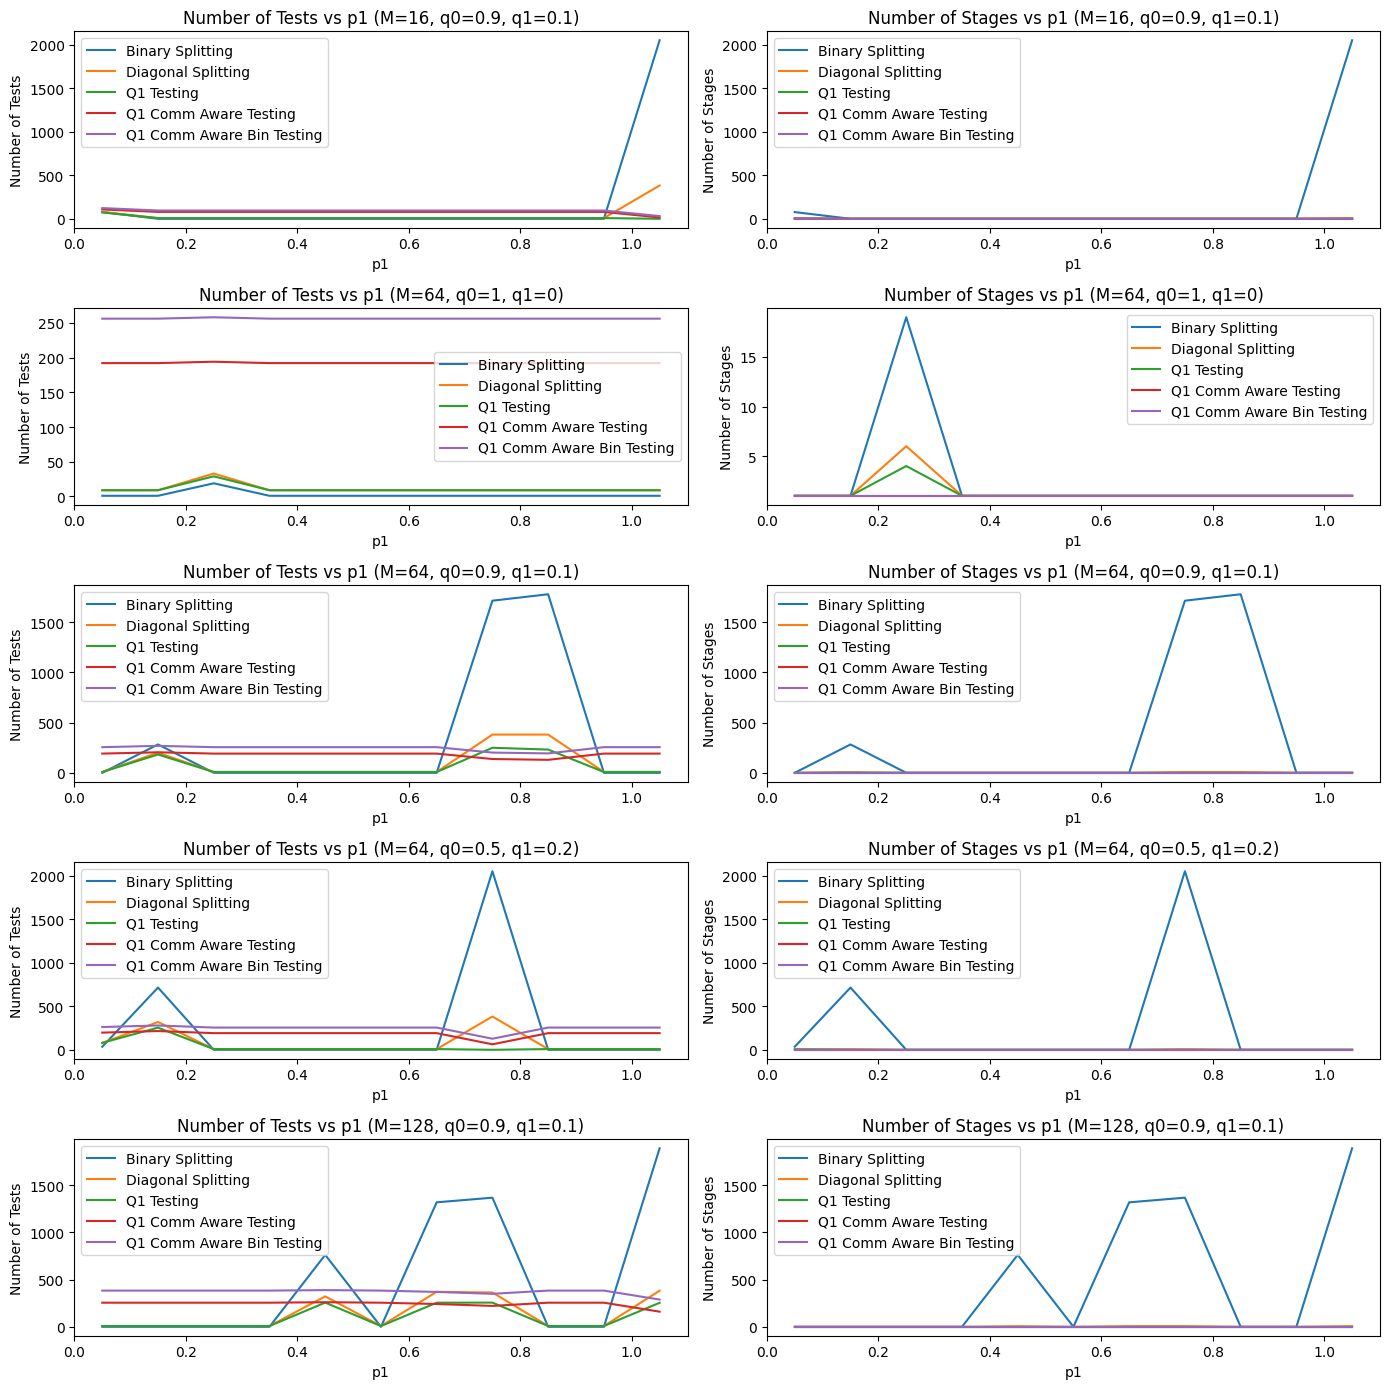

In [156]:
# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"binary": [], "diag": [], "Q1": [], "Q1Comm": [], "Q1Comm_bin": []} for ps in parameter_sets}

# Run simulations
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        # infection_progression = infect(G, p0, p1, time_steps)
        final_state = infect(G, p0, p1, time_steps)

        binary_tests, binary_stages = binary_splitting(final_state)[0:2]
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
        Q1Comm_bin_tests, Q1Comm_bin_stages = Qtesting1_comm_aware_bin(final_state, communities)

        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests, binary_stages))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests, diag_stages))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests, Q1_stages))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests, Q1Comm_stages))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"].append((Q1Comm_bin_tests, Q1Comm_bin_stages))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"]], label='Q1 Comm Aware Bin Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"]], label='Q1 Comm Aware Bin Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()



# # Set the parameters from Table 3
# N = 1024
# parameter_sets = [
#     (64, 0.9, 0.1, 0.01, 2)
# ]

# # Initialize lists to store results
# p1_values = np.arange(0.05, 1.1, 0.1)
# results = {ps: {"binary": [], "diag": [], "Q1": [], "Q1Comm": [], "Q1Comm_bin": []} for ps in parameter_sets}

# # Run simulations
# for (M, q0, q1, p0, time_steps) in parameter_sets:
#     for p1 in p1_values:
#         G = SBM(N, M, q0, q1)
#         communities = create_communities(N, M)
#         # infection_progression = infect(G, p0, p1, time_steps)
#         final_state = infect(G, p0, p1, time_steps)

#         binary_tests, binary_stages = binary_splitting(final_state)[0:2]
#         diag_tests, diag_stages = diag_splitting(final_state)
#         Q1_tests, Q1_stages = Qtesting1(final_state)
#         Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
#         Q1Comm_bin_tests, Q1Comm_bin_stages = Qtesting1_comm_aware_bin(final_state, communities)

#         results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests, binary_stages))
#         results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests, diag_stages))
#         results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests, Q1_stages))
#         results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests, Q1Comm_stages))
#         results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"].append((Q1Comm_bin_tests, Q1Comm_bin_stages))

# # Plotting the results
# plt.figure(figsize=(14, 14))

# for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
#     plt.subplot(len(parameter_sets), 2, 2*idx + 1)
#     plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
#     plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
#     plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
#     plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
#     plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"]], label='Q1 Comm Aware Bin Testing')
#     plt.xlabel('p1')
#     plt.ylabel('Number of Tests')
#     plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
#     plt.legend()

#     plt.subplot(len(parameter_sets), 2, 2*idx + 2)
#     plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
#     plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
#     plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
#     plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
#     plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm_bin"]], label='Q1 Comm Aware Bin Testing')
#     plt.xlabel('p1')
#     plt.ylabel('Number of Stages')
#     plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
#     plt.legend()

# plt.tight_layout()
# plt.show()

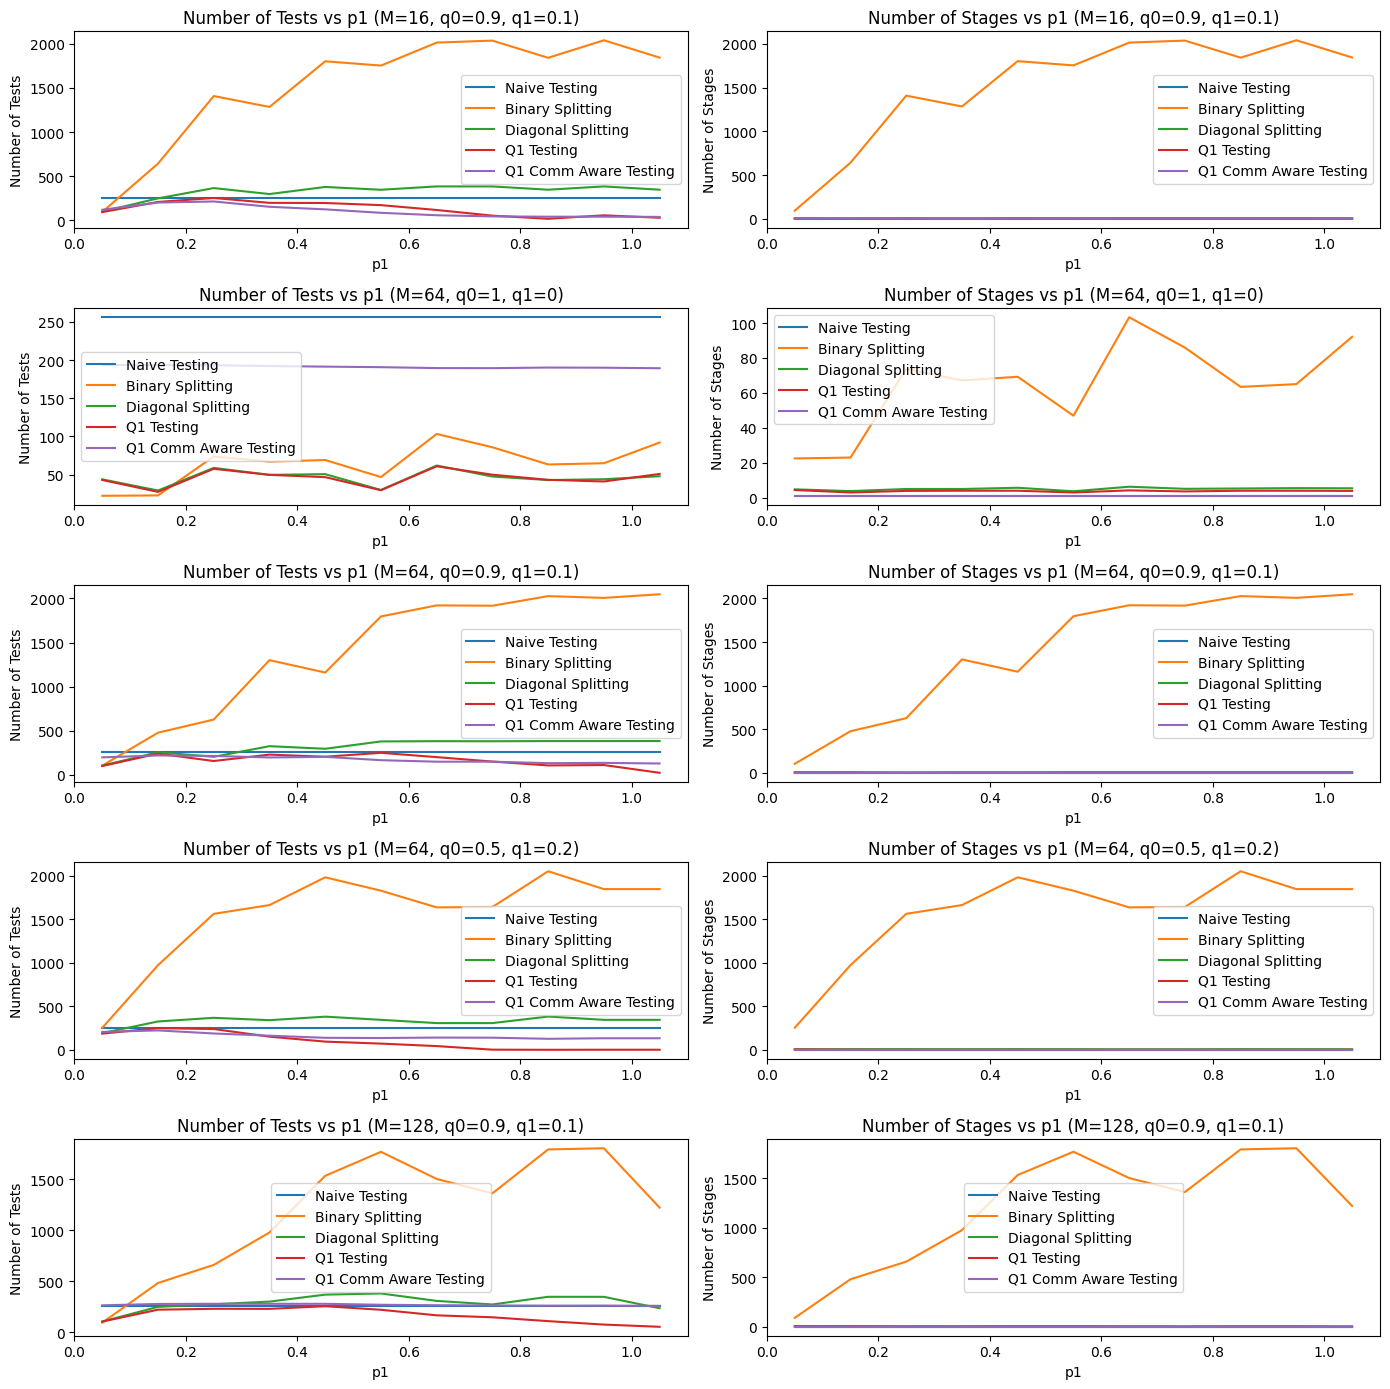

In [ ]:
# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"naive": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 10
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        naive_tests_total, naive_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            infection_progression = infect(G, p0, p1, time_steps)
            final_state = infection_progression

            naive_tests, naive_stages = naive_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

            naive_tests_total += naive_tests
            naive_stages_total += naive_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages

        results[(M, q0, q1, p0, time_steps)]["naive"].append((naive_tests_total / num_simulations, naive_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()
